In [1]:
%%capture
!pip install yfinance

# Simple Momentum Strategy  
## This version works in colab
Our first algorithmic trading (buy when the price is low, and sell when the price is high), for the buy low sell high example, we will calculate the difference in the adjusted close between two consecutive days. If the value of the adjusted close difference is negative, this means the price on the previous day was higher than the price the following day, so we can buy since the price is lower now. If this value is positive, this means that we can sell because the price is higher.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance

import yfinance as yf
import pickle

start_date = '2020-01-01'
end_date = '2021-12-31'

google_daily=yf.download('GOOG', start_date, end_date)
google_daily.to_pickle('google_daily.pkl')

module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


In [3]:
google_daily.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000


## We use 'Adj Close' to represend daily price
### What is  'Adjusted Close'??

In [4]:

google_daily_signal=pd.DataFrame(index=google_daily.index)
google_daily_signal['price'] = google_daily['Adj Close']

#to check the trading signal, create the daily price change 
google_daily_signal['daily_difference'] = google_daily_signal['price'].diff()

#separate the dates when the prices has advanced or declined
# 1: advanced; 0 otherwise
google_daily_signal['signal'] = 0.0
google_daily_signal['signal'][:] = np.where(google_daily_signal['daily_difference'][:] > 0, 1.0, 0.0)

google_daily_signal[:20]

,price,daily_difference,signal
Date,,,
2020-01-02,1367.369995,NaN,0.0
2020-01-03,1360.660034,-6.709961,0.0
2020-01-06,1394.209961,33.549927,1.0
2020-01-07,1393.339966,-0.869995,0.0
2020-01-08,1404.319946,10.979980,1.0
2020-01-09,1419.829956,15.510010,1.0
2020-01-10,1429.729980,9.900024,1.0
2020-01-13,1439.229980,9.500000,1.0
2020-01-14,1430.880005,-8.349976,0.0


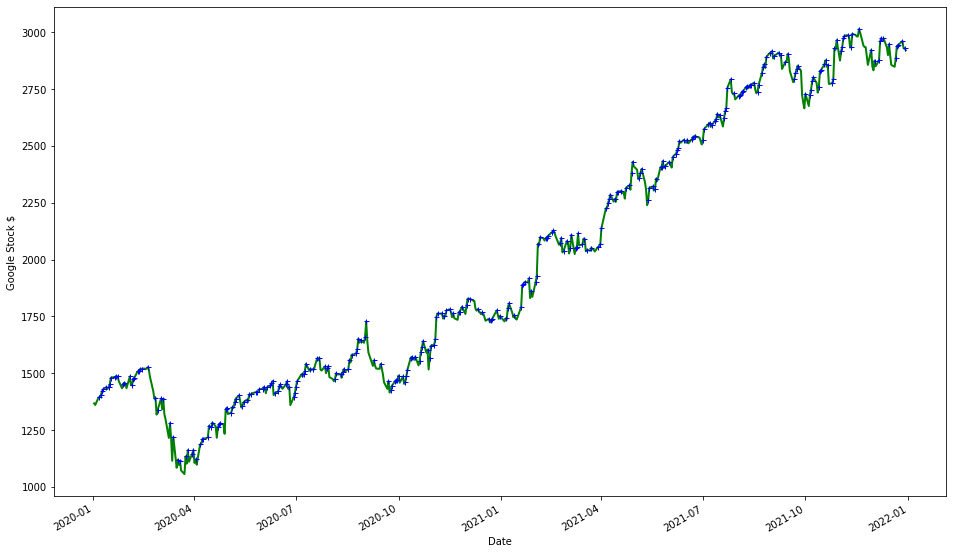

In [5]:
fig = plt.figure(figsize=(16,10))

ax0 = fig.add_subplot(111, ylabel='Google Stock $')
google_daily_signal['price'].plot(ax=ax0, color='g', lw=2.)

ax0.plot(google_daily_signal.loc[google_daily_signal.signal == 1.0].index,
         google_daily_signal.price[google_daily_signal.signal == 1.0], '+', markersize=5, color='b')


## Before we start, let's look at the time serials autocorrelation

In [6]:

import statsmodels.api as sm
sm.tsa.acf(google_daily_signal['price'],nlags=10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([1.        , 0.9947233 , 0.98975325, 0.98467493, 0.97965372,
       0.97481318, 0.97017158, 0.96590095, 0.96143753, 0.95706025,
       0.9521497 ])

#### It does show strong serial correlations

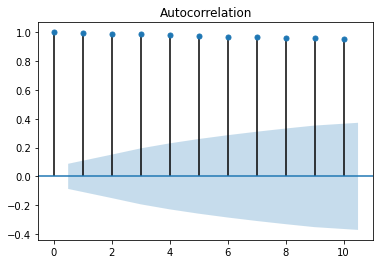

In [7]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(google_daily_signal['price'],lags=10)
plt.show()

Since we don't want to constantly buy if the market keeps moving down, or constantly sell 
when the market is moving up, we will limit the number of orders by restricting ourselves 
to the number of positions on the market. The position is your inventory of stocks or 
assets that you have on the market. For instance, if you buy one Google share, this means 
you have a position of one share on the market. If you sell this share, you will not have 
any positions on the market.

# Question: Can you see the problem if we use this as the buy signal? How should we improve it?

In [8]:
google_daily_signal['positions'] = google_daily_signal['signal'].diff()

In [9]:
google_daily_signal[:20]

,price,daily_difference,signal,positions
Date,,,,
2020-01-02,1367.369995,NaN,0.0,NaN
2020-01-03,1360.660034,-6.709961,0.0,0.0
2020-01-06,1394.209961,33.549927,1.0,1.0
2020-01-07,1393.339966,-0.869995,0.0,-1.0
2020-01-08,1404.319946,10.979980,1.0,1.0
2020-01-09,1419.829956,15.510010,1.0,0.0
2020-01-10,1429.729980,9.900024,1.0,0.0
2020-01-13,1439.229980,9.500000,1.0,0.0
2020-01-14,1430.880005,-8.349976,0.0,-1.0


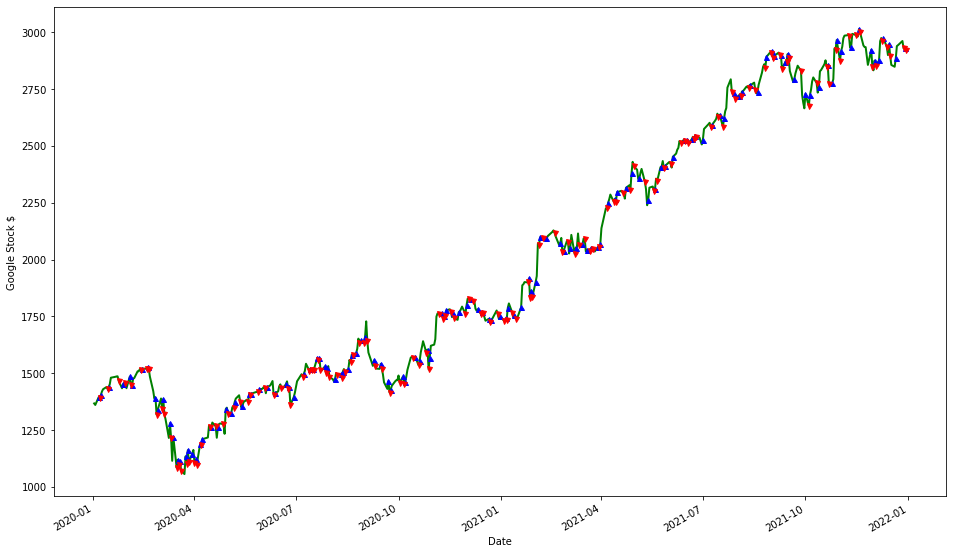

In [10]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(111, ylabel='Google Stock $')
google_daily_signal['price'].plot(ax=ax1, color='g', lw=2.)

#plot the price when buying
ax1.plot(google_daily_signal.loc[google_daily_signal.positions == 1.0].index,
         google_daily_signal.price[google_daily_signal.positions == 1.0], '^', markersize=5, color='b')

#plot the price when selling
ax1.plot(google_daily_signal.loc[google_daily_signal.positions == -1.0].index,
         google_daily_signal.price[google_daily_signal.positions == -1.0],
         'v', markersize=5, color='r')
plt.savefig('buy-sell.jpg')

### Compute the PnL

In [11]:
#Backtesting
#PnL: initially we invest $1000
initial_capital= float(1000.0)

positions = pd.DataFrame(index=google_daily_signal.index).fillna(0.0)
portfolio = pd.DataFrame(index=google_daily_signal.index).fillna(0.0)


positions['GOOG'] = google_daily_signal['signal']
portfolio['positions'] = (positions.multiply(google_daily_signal['price'], axis=0))
portfolio['cash'] = initial_capital - (positions.diff().multiply(google_daily_signal['price'], axis=0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']

portfolio[:20]

,positions,cash,total
Date,,,
2020-01-02,0.000000,NaN,NaN
2020-01-03,0.000000,1000.000000,1000.000000
2020-01-06,1394.209961,-394.209961,1000.000000
2020-01-07,0.000000,999.130005,999.130005
2020-01-08,1404.319946,-405.189941,999.130005
2020-01-09,1419.829956,-405.189941,1014.640015
2020-01-10,1429.729980,-405.189941,1024.540039
2020-01-13,1439.229980,-405.189941,1034.040039
2020-01-14,0.000000,1025.690063,1025.690063


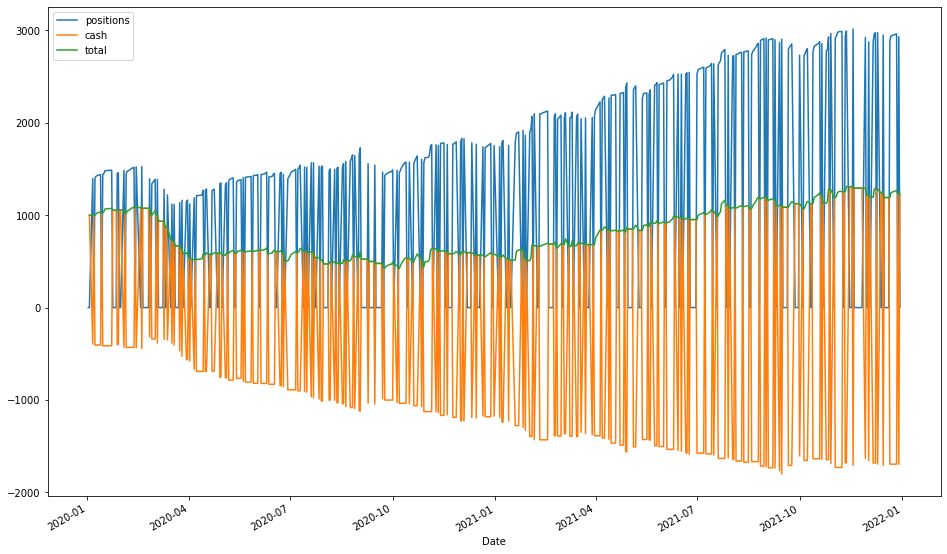

In [12]:
portfolio.plot(figsize=(16,10))
plt.savefig('google_pnl.jpg')
plt.show()

In [13]:
portfolio.total[-1]

1224.9456787109375

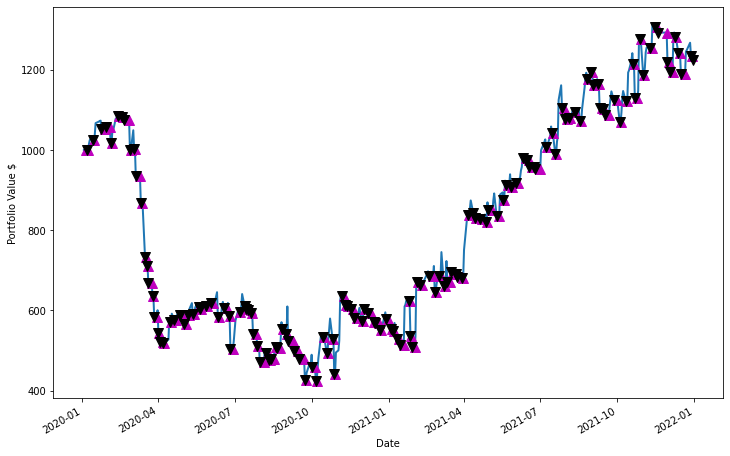

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Portfolio Value $')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[google_daily_signal.positions == 1.0].index,portfolio.total[google_daily_signal.positions == 1.0],'^', markersize=10, color='m')
ax1.plot(portfolio.loc[google_daily_signal.positions == -1.0].index,portfolio.total[google_daily_signal.positions == -1.0],'v', markersize=10, color='k')

plt.show() 



## Does it actually work in reality?
## See the examples when replacing google stock by tesla and MacDonald
## How to make it "implementable" in reality?

# Support and Resistance

In [15]:
import pickle
google_daily=pd.read_pickle('google_daily.pkl')

# We draw the highs and lows of the GOOG price.
The green line represents the resistance level, and the red line represents the support level.
To build these lines, we use the maximum value of the GOOG price and the minimum value of the GOOG price stored daily.
After the 200th day (dotted vertical blue line), we will buy when we reach the support line, and sell when we reach the resistance line. In this example, we used 200 days so that we have sufficient data points to get an estimate of the trend.
It is observed that the GOOG price will reach the resistance line around November 2020. This means that we have a signal to enter a short position (sell). 
Once traded, we will wait to get out of this short position when the GOOG price will reach the support line.
With this historical data, it is easily noticeable that this condition will not happen.
This will result in carrying a short position in a rising market without having any signal to sell it, thereby resulting in a huge loss.
This means that, even if the trading idea based on support/resistance has strong grounds in terms of economical behavior, in reality, we will need to modify this trading strategy to make it work.
Moving the support/resistance line to adapt to the market evolution will be key to the trading strategy efficiency.

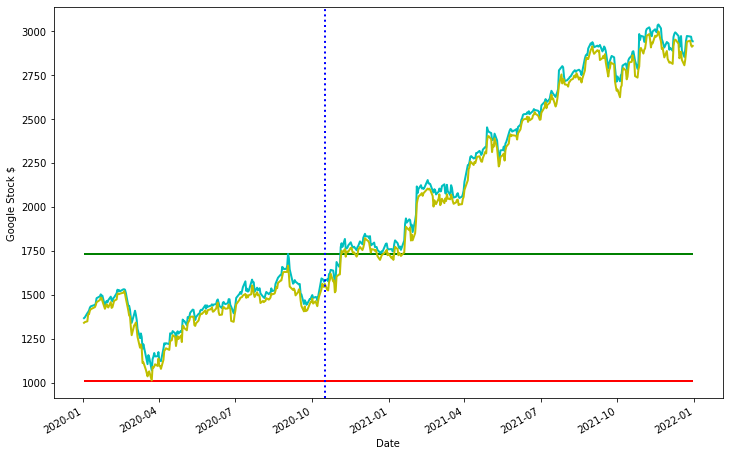

In [16]:
lows=google_daily['Low']
highs=google_daily['High']

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Google Stock $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1] ,linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1], linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':') 
plt.savefig('google_support_and_resistance.jpg')
plt.show()

# We add more parameters to change the behavior in order to enter a position. The following parameters can be added to the algorithm to change its position:
There can be a shorter rolling window.
We can count the number of times the price reaches a support or resistance line. A tolerance margin can be added to consider that a support or resistance value can attain around a certain percentage of this value.

We can count the number of times the price reaches a support or resistance line and set the minimum number of times that a price needs to reach the support/resistance level.
We will define the tolerance margin of what we consider being close to the support/resistance level.

In [17]:
google_daily_signal = pd.DataFrame(index=google_daily.index) 
google_daily_signal['price'] = google_daily['Adj Close']

In [18]:
def trading_support_resistance(data, bin_width=20):   #By default we check for 20 days interval
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))   
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))   
    data['sup_count'] = pd.Series(np.zeros(len(data)))   
    data['res_count'] = pd.Series(np.zeros(len(data)))   
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))   
    data['signal'] = pd.Series(np.zeros(len(data)))
    
    in_support=0
    in_resistance=0
    
    for x in range(bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['price'])
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level 
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
        if data['price'][x]>=data['res_tolerance'][x] and data['price'][x] <= data['res'][x]: 
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]: 
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0 
            in_resistance=0
        if in_resistance>2:           #if reached twice
            data['signal'][x]=1 
        elif in_support>2:
            data['signal'][x]=0 
        else:
            data['signal'][x] = data['signal'][x-1]
    data['positions']=data['signal'].diff()   


In [19]:
trading_support_resistance(google_daily_signal)
google_daily_signal[150:160]

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2020-08-06,1500.099976,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-07,1494.489990,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-10,1496.099976,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-11,1480.319946,1485.673975,1547.785986,1.0,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-12,1506.619995,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-13,1518.449951,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-14,1507.729980,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-17,1517.979980,1485.673975,1547.785986,NaN,NaN,1464.969971,1568.48999,0.0,0.0
2020-08-18,1558.599976,1485.673975,1547.785986,NaN,1.0,1464.969971,1568.48999,0.0,0.0


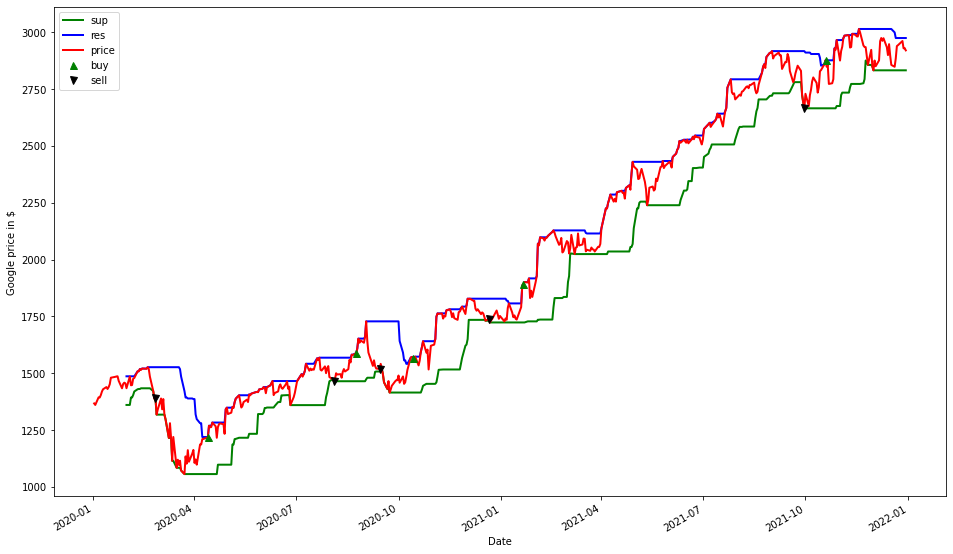

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
google_daily_signal['sup'].plot(ax=ax1, color='g', lw=2.)
google_daily_signal['res'].plot(ax=ax1, color='b', lw=2.)
google_daily_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(google_daily_signal.loc[google_daily_signal.positions == 1.0].index,
google_daily_signal.price[google_daily_signal.positions == 1.0],'^', markersize=7, color='g',label='buy')
ax1.plot(google_daily_signal.loc[google_daily_signal.positions == -1.0].index,
         google_daily_signal.price[google_daily_signal.positions == -1.0], 'v', markersize=7, color='k',label='sell')
plt.legend() 
plt.savefig('moving_sup_res.jpg')
plt.show()

### Backtesting the strategy

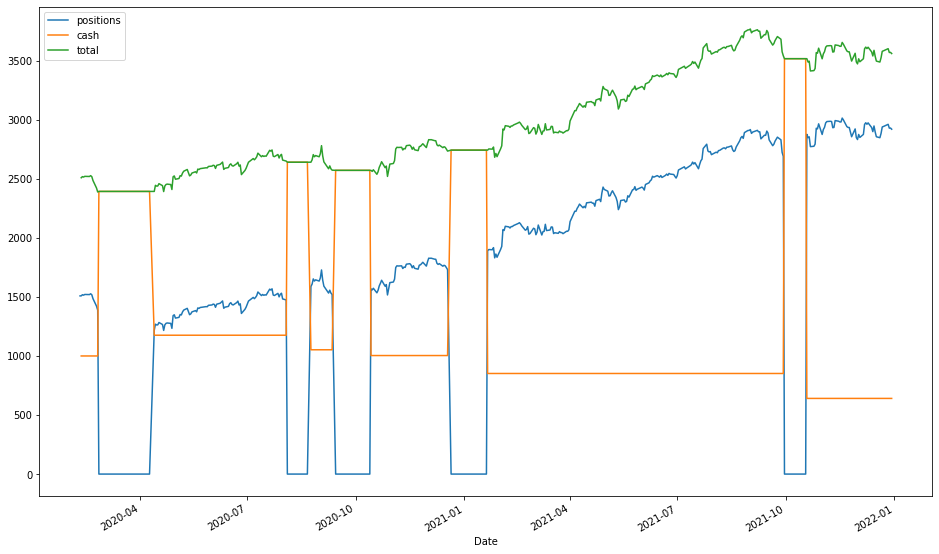

In [21]:
#PnL: initially we invest $1000
initial_capital= float(1000.0)

positions = pd.DataFrame(index=google_daily_signal.index).fillna(0.0)
portfolio = pd.DataFrame(index=google_daily_signal.index).fillna(0.0)


positions['GOOG'] = google_daily_signal['signal']
portfolio['positions'] = (positions.multiply(google_daily_signal['price'], axis=0))
portfolio['cash'] = initial_capital - (positions.diff().multiply(google_daily_signal['price'], axis=0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']
portfolio.plot(figsize=(16,10))
plt.savefig('moving_sup_res_pnl.jpg')
plt.show()


In [22]:
portfolio.total[-1]

3560.6302490234375

# Trading signals based on fundamental technical analysis

## Implementation of the simple moving average

In [23]:
import statistics as stats
time_period = 20 # leng of the window
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values

import pickle
google_daily=pd.read_pickle('google_daily.pkl')

close=google_daily['Adj Close']


In [24]:
close.head(3)

Date
2020-01-02    1367.369995
2020-01-03    1360.660034
2020-01-06    1394.209961
Name: Adj Close, dtype: float64

In [25]:
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
        del (history[0])
    sma_values.append(stats.mean(history))

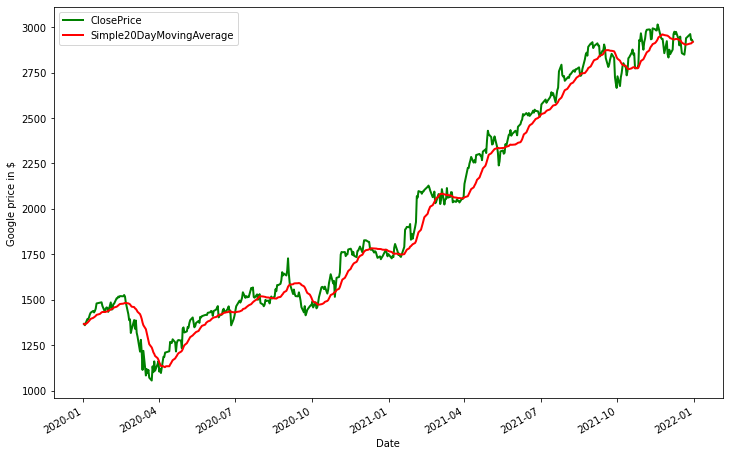

In [26]:

google_daily = google_daily.assign(ClosePrice=pd.Series(close, index=google_daily.index))
google_daily = google_daily.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=google_daily.index))
close_price = google_daily['ClosePrice']
sma = google_daily['Simple20DayMovingAverage']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)

plt.savefig('Simple20DayMovingAverage.jpg')
plt.show()


## Implementation of the exponential moving average

We will use a default smoothing factor of 2 / (N + 1)


In [27]:
import statistics as stats
time_period = 20 # leng of the window
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values

import pickle
google_daily=pd.read_pickle('google_daily.pkl')

close=google_daily['Adj Close']

num_periods = 20 # number of days over which to average 
lam=2.0/(num_periods + 1) # smoothing constant

ema_p = 0
ema_values = [] # to hold computed EMA values

for close_price in close:
    if (ema_p == 0): # first observation, EMA = current-price
        ema_p = close_price
    else:
        ema_p = close_price * lam + ema_p*(1-lam)
    ema_values.append(ema_p)
    
google_daily = google_daily.assign(ClosePrice=pd.Series(close, index=google_daily.index))
google_daily = google_daily.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=google_daily.index))
#close_price = google_daily['ClosePrice']
ema = google_daily['Exponential20DayMovingAverage']


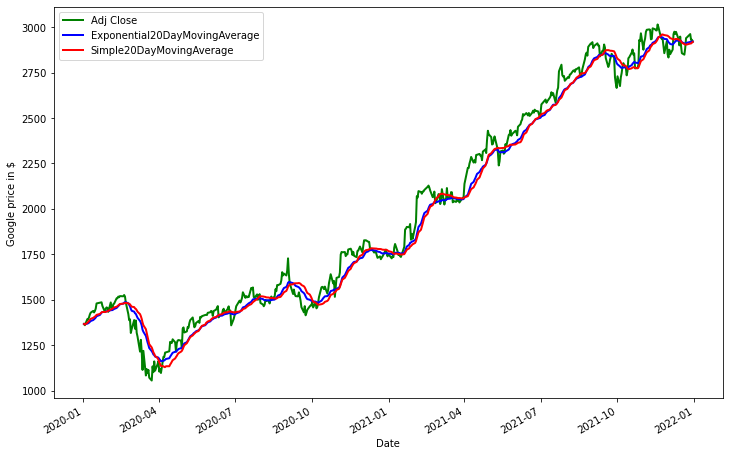

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close.plot(ax=ax1, color='g', lw=2., legend=True)
ema.plot(ax=ax1, color='b', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)
plt.savefig('ema.png')
plt.savefig('Exponential20DayMovingAverage.jpg')
plt.show()

# Absolute price oscillator

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
google_daily=pd.read_pickle('google_daily.pkl') 

In [30]:
google_daily.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300


In [31]:
num_of_periods_fast=10
num_of_periods_slow=40
ema_fast=0
ema_fast_values=[]

lam_fast=2.0/(num_of_periods_fast+1)
lam_slow=2.0/(num_of_periods_slow+1)
ema_slow=0
ema_slow_values=[]

apo_values=[]

close=google_daily['Adj Close'] # use adjusted close for closing price
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = lam_fast*close_price+(1-lam_fast)*ema_fast
        ema_slow = lam_slow*close_price+(1-lam_slow)*ema_slow
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

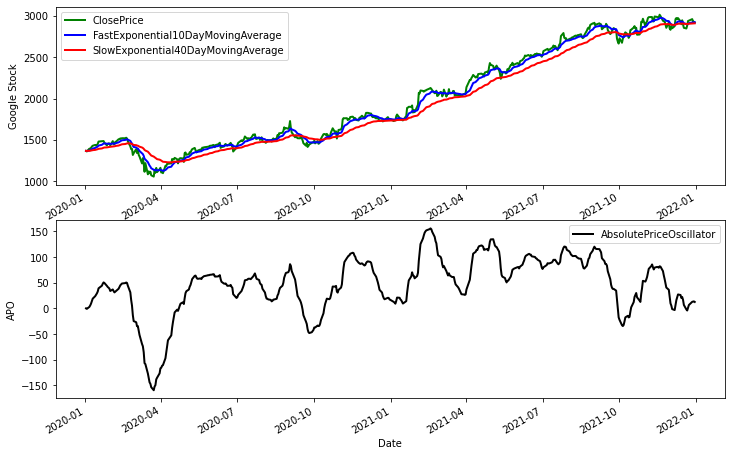

In [32]:
#PLot
google_daily = google_daily.assign(ClosePrice=pd.Series(close,index=google_daily.index))
google_daily = google_daily.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=google_daily.index))
google_daily = google_daily.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=google_daily.index))
google_daily = google_daily.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=google_daily.index))

close_price = google_daily['ClosePrice']
ema_f = google_daily['FastExponential10DayMovingAverage']
ema_s = google_daily['SlowExponential40DayMovingAverage']
apo = google_daily['AbsolutePriceOscillator']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211, ylabel='Google Stock')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.savefig('apo.jpg')
plt.show()


## Implementation of the moving average convergence divergence

In [33]:
import pickle
google_daily=pd.read_pickle('google_daily.pkl') 

num_of_periods_fast=10
num_of_periods_slow=40
num_of_periods_macd=20

ema_fast=0
ema_fast_values=[]

ema_slow=0
ema_slow_values=[]

ema_macd=0

macd_values=[]
macd_signal_values = [] 
macd_histogram_values = [] 

lam_fast=2.0/(num_of_periods_fast+1)
lam_slow=2.0/(num_of_periods_slow+1)
lam_macd=2.0/(num_of_periods_macd+1)

close=google_daily['Adj Close'] # use adjusted close for closing price

for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price    
        ema_slow = close_price  
    else:
        ema_fast = lam_fast*close_price + (1-lam_fast)*ema_fast    
        ema_slow = lam_slow*close_price + (1-lam_slow)*ema_slow
    
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA    
    
    if ema_macd == 0:
        ema_macd = macd
    else:
        ema_macd = lam_macd*macd+(1-lam_macd)*ema_macd # signal is EMA of MACD values
    
    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    macd_histogram_values.append(macd - ema_macd)

### visualize the different signals


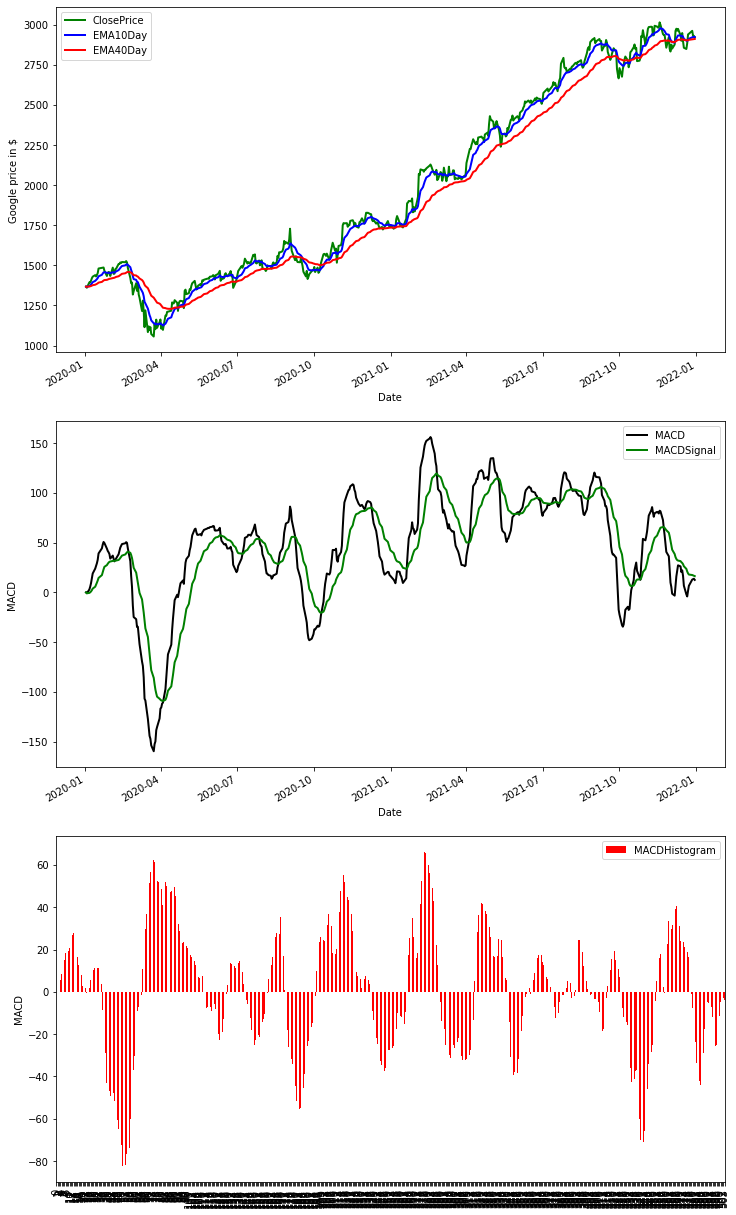

In [34]:
google_daily = google_daily.assign(ClosePrice=pd.Series(close, index=google_daily.index))
google_daily = google_daily.assign(EMA10Day=pd.Series(ema_fast_values, index=google_daily.index))
google_daily = google_daily.assign(EMA40Day=pd.Series(ema_slow_values, index=google_daily.index))
google_daily = google_daily.assign(MACD=pd.Series(macd_values, index=google_daily.index))
google_daily = google_daily.assign(MACDSignal=pd.Series(macd_signal_values, index=google_daily.index))
google_daily = google_daily.assign(MACDHistogram=pd.Series(macd_histogram_values, index=google_daily.index))

close_price = google_daily['ClosePrice']
ema_f = google_daily['EMA10Day']
ema_s = google_daily['EMA40Day']
macd = google_daily['MACD']
ema_macd = google_daily['MACDSignal'] 
macd_histogram = google_daily['MACDHistogram']

fig = plt.figure(figsize=(12,24))

ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)

ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)

ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.savefig('macd.jpg')
plt.show()

## Implementation of Bollinger bands
We will implement and visualize Bollinger bands, with 20 days as the time period for SMA

In [35]:
import pickle
google_daily=pd.read_pickle('google_daily.pkl') 

close=google_daily['Adj Close'] # use adjusted close for closing price

In [36]:
import statistics as stats
import math as math

num_of_periods = 20 # history length for Simple Moving Average for middle band stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
stdev_factor=2.0

history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes 
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
    history.append(close_price)
    if len(history) > num_of_periods: # we only want to maintain at most 'num_of_periods' number of price observations
        del(history[0])
    sma = stats.mean(history)
    sma_values.append(sma) # simple moving average or middle band
    variance = 0 # variance is the square of standard deviation  
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)
        stdev = math.sqrt(variance / len(history)) # use square root to get std
    upper_band.append(sma + stdev_factor * stdev)  
    lower_band.append(sma - stdev_factor * stdev)        

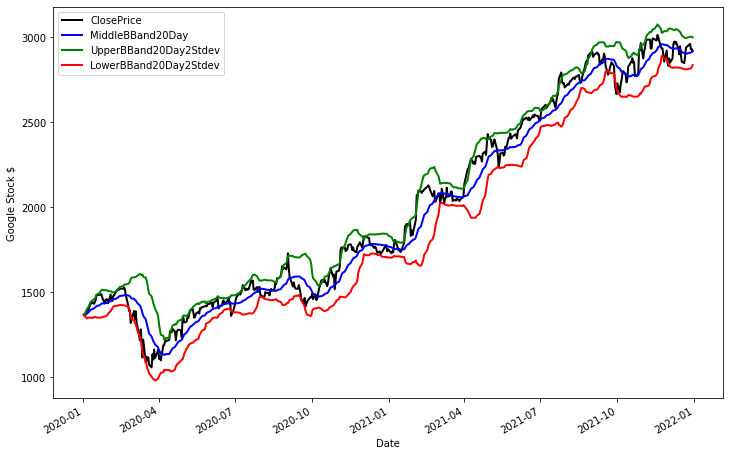

In [37]:
#Visualize
google_daily = google_daily.assign(ClosePrice=pd.Series(close,index=google_daily.index))
google_daily = google_daily.assign(MiddleBBand20Day=pd.Series(sma_values,index=google_daily.index))
google_daily = google_daily.assign(UpperBBand20Day2Stdev=pd.Series(upper_band, index=google_daily.index))
google_daily = google_daily.assign(LowerBBand20Day2Stdev=pd.Series(lower_band, index=google_daily.index))

close_price = google_daily['ClosePrice'] 
mband = google_daily['MiddleBBand20Day']
uband = google_daily['UpperBBand20Day2Stdev']
lband = google_daily['LowerBBand20Day2Stdev']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Google Stock $')
close_price.plot(ax=ax1, color='k', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True) 
uband.plot(ax=ax1, color='g', lw=2., legend=True) 
lband.plot(ax=ax1, color='r', lw=2., legend=True) 
plt.savefig('bollinger_band.jpg')
plt.show()

## RSI

In [38]:
import pickle
google_daily=pd.read_pickle('google_daily.pkl') 
google_daily

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000
...,...,...,...,...,...,...
2021-12-23,2941.790039,2971.451904,2939.017090,2942.850098,2942.850098,690900
2021-12-27,2949.270020,2968.530029,2945.000000,2961.280029,2961.280029,662800
2021-12-28,2967.489990,2967.489990,2918.709961,2928.959961,2928.959961,931200


In [39]:
import statistics as stats

num_of_periods = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)

avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values

last_price = 0 # current_price - last_price > 0 => gain. current_price -last_price < 0 => loss.

close=google_daily['Adj Close'] # use adjusted close for closing price

for close_price in close:
    if last_price == 0:
          last_price = close_price 
    gain_history.append(max(0, close_price - last_price))  
    loss_history.append(max(0, last_price - close_price))  
    last_price = close_price
    
    if len(gain_history) > num_of_periods: # maximum observations is equal to lookback period
            del (gain_history[0])
            del (loss_history[0])
            
    avg_gain = stats.mean(gain_history) # average gain over lookback period  
    avg_loss = stats.mean(loss_history) # average loss over lookback period  avg_gain_values.append(avg_gain)
    
    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)

    rs = 0
    if avg_loss > 0: # to avoid division by 0, which is undefined
        rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)
    

In [40]:
google_daily.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1341.550049,1368.140015,1341.550049,1367.369995,1367.369995,1406600
2020-01-03,1347.859985,1372.500000,1345.543945,1360.660034,1360.660034,1186400
2020-01-06,1350.000000,1396.500000,1350.000000,1394.209961,1394.209961,1732300
2020-01-07,1397.939941,1402.989990,1390.380005,1393.339966,1393.339966,1502700
2020-01-08,1392.079956,1411.579956,1390.839966,1404.319946,1404.319946,1528000


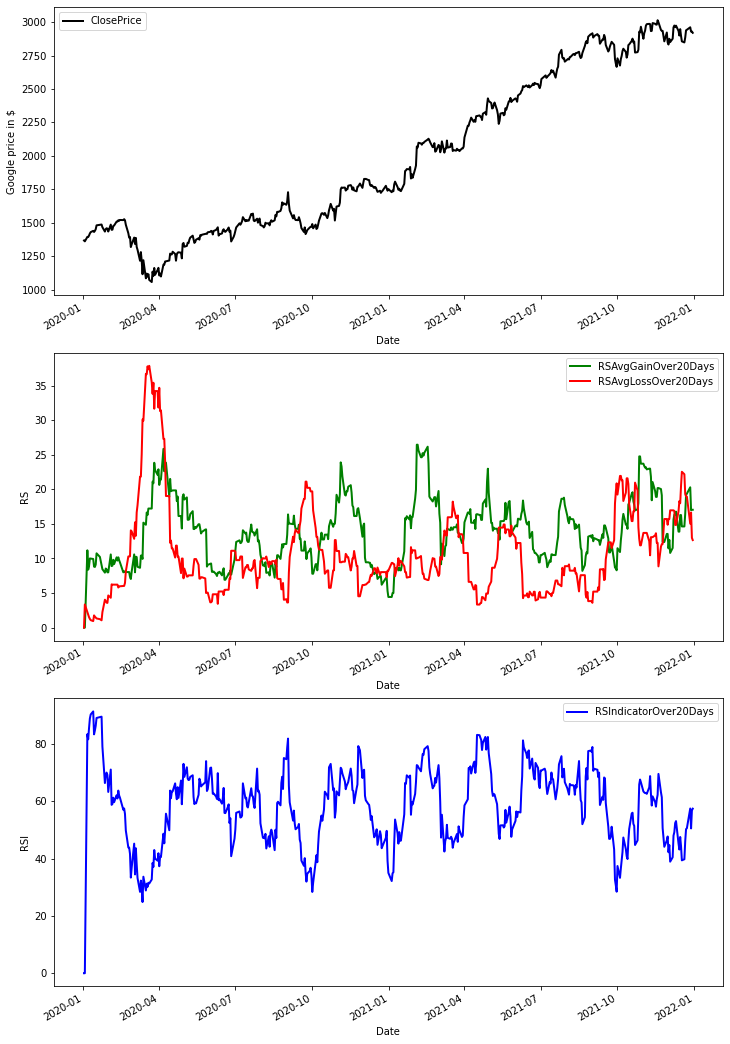

In [41]:
google_daily = google_daily.assign(ClosePrice=pd.Series(close,index=google_daily.index))
google_daily = google_daily.assign(RSAvgGainOver20Days=pd.Series(avg_gain_values, index=google_daily.index))
google_daily = google_daily.assign(RSAvgLossOver20Days=pd.Series(avg_loss_values, index=google_daily.index))
google_daily = google_daily.assign(RSIndicatorOver20Days=pd.Series(rsi_values, index=google_daily.index))

close_price = google_daily['ClosePrice']
rs_gain = google_daily['RSAvgGainOver20Days']
rs_loss = google_daily['RSAvgLossOver20Days']
rsi = google_daily['RSIndicatorOver20Days']

fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)
plt.savefig('rsi.jpg')
plt.show()

## Standard deviation

In [42]:
try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance

import yfinance as yf

start_date = '2004-08-19'
end_date = '2021-12-31'

google_daily =yf.download('GOOG', start_date, end_date)
sp500_daily=yf.download('^GSPC', start_date, end_date)

close=google_daily['Adj Close']

module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


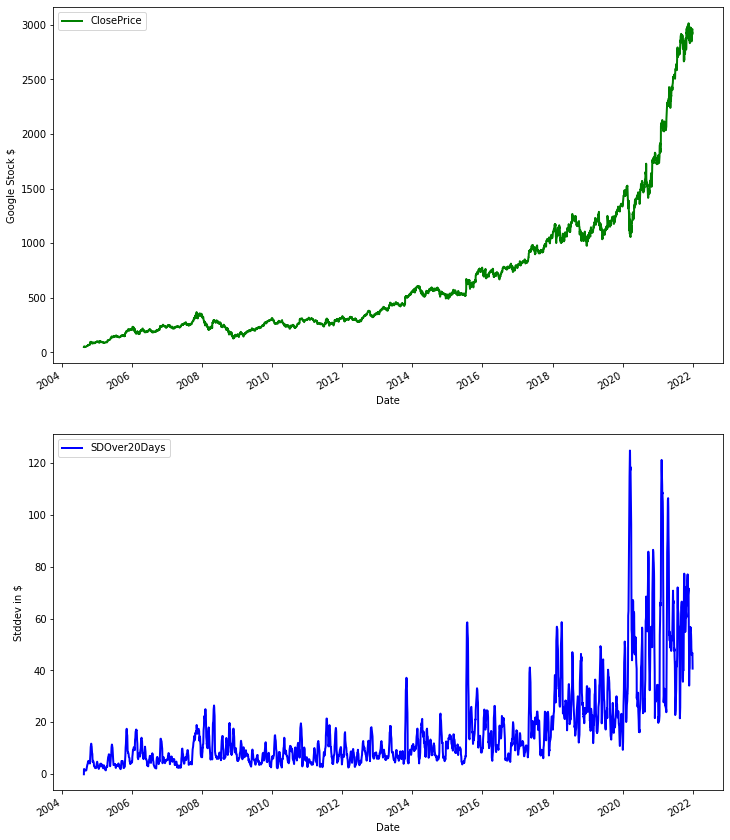

In [43]:
import pandas as pd
import statistics as stats
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
num_of_periods=20

history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes 
stddev_values = [] # history of computed stdev values

for close_price in close:
    history.append(close_price)
    if len(history) > num_of_periods: # we track at most 'time_period' number of prices
        del (history[0])
    sma = stats.mean(history)
    sma_values.append(sma)    
    
    variance = 0 # variance is square of standard deviation  
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)
    stdev = math.sqrt(variance / len(history))  
    stddev_values.append(stdev)
    
google_daily = google_daily.assign(ClosePrice=pd.Series(close, index=google_daily.index))
google_daily = google_daily.assign(SDOver20Days=pd.Series(stddev_values, index=google_daily.index))
close_price = google_daily['ClosePrice']
stddev = google_daily['SDOver20Days']

fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(211, ylabel='Google Stock $') 
close_price.plot(ax=ax1, color='g', lw=2., legend=True) 

ax2 = fig.add_subplot(212, ylabel='Stddev in $') 
stddev.plot(ax=ax2, color='b', lw=2., legend=True) 
plt.savefig('stdev20days.jpg')
plt.show()

## Momentum

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
google_daily=pd.read_pickle('google_daily.pkl') 

close=google_daily['Adj Close'] # use adjusted close for closing price

In [45]:
num_of_periods = 20 # how far to look back to find reference price to compute momentum

history = [] # history of observed prices to use in momentum calculation 
mom_values = [] # track momentum values for visualization purposes

for close_price in close:
    history.append(close_price)
    if len(history) > num_of_periods: # history is at most 'time_period' number of observations
        del (history[0])
    mom = close_price - history[0]  
    mom_values.append(mom)

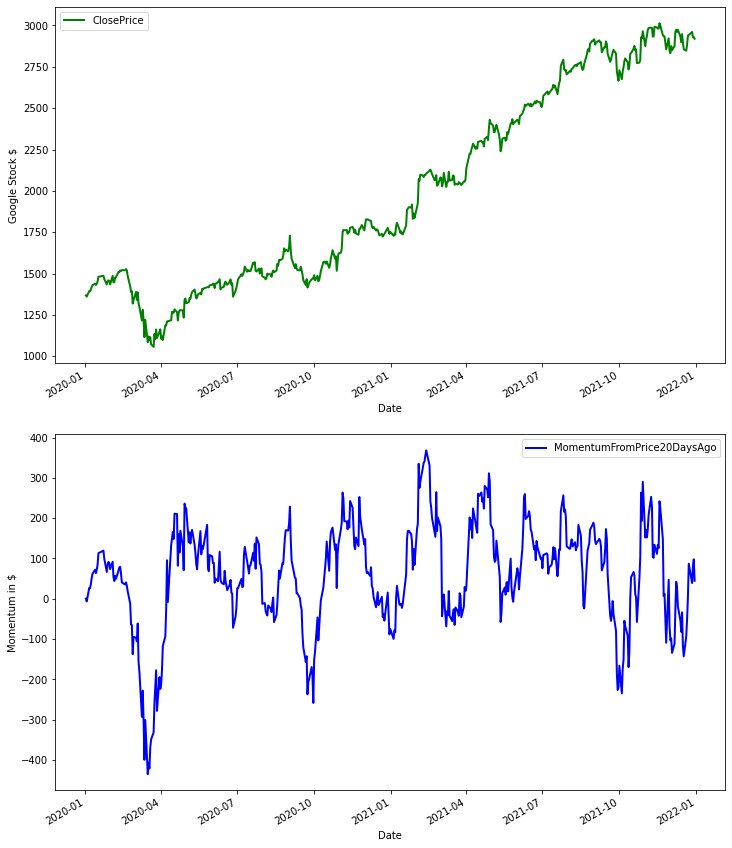

In [46]:
google_daily = google_daily.assign(ClosePrice=pd.Series(close, index=google_daily.index))
google_daily = google_daily.assign(MomentumFromPrice20DaysAgo=pd.Series(mom_values, index=google_daily.index))
close_price = google_daily['ClosePrice']
mom = google_daily['MomentumFromPrice20DaysAgo']

fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(211, ylabel='Google Stock $') 
close_price.plot(ax=ax1, color='g', lw=2., legend=True) 

ax2 = fig.add_subplot(212, ylabel='Momentum in $') 
mom.plot(ax=ax2, color='b', lw=2., legend=True)
plt.savefig('momentum20days.jpg')
plt.show()

# Implementing advanced concepts, such as seasonality
We will write the code to regroup the data by months, calculate the monthly returns, and then compare these returns in a histogram.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance

import yfinance as yf
start_date = '2000-01-01'
end_date = '2021-12-31'

google_daily_long = yf.download('GOOG', start_date, end_date)

module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


In [48]:
import pickle
google_daily_long.to_pickle('google_daily_long.pkl')

In [49]:
google_monthly_return = google_daily_long['Adj Close'].pct_change().groupby(
    [google_daily_long['Adj Close'].index.year,
     google_daily_long['Adj Close'].index.month]).mean()
google_monthly_return[:20]

Date  Date
2004  8       0.003137
      9       0.011525
      10      0.019399
      11     -0.001554
      12      0.002802
2005  1       0.001142
      2      -0.001720
      3      -0.001768
      4       0.009677
      5       0.011207
      6       0.002914
      7      -0.000969
      8      -0.000176
      9       0.004939
      10      0.008182
      11      0.004193
      12      0.001239
2006  1       0.002643
      2      -0.008644
      3       0.003494
Name: Adj Close, dtype: float64

In [50]:
google_monthly_return_list=[]

for i in range(len(google_monthly_return)):
    google_monthly_return_list.append({'month':google_monthly_return.index[i][1],
          'monthly_return': google_monthly_return.values[i]})

google_monthly_return_list=pd.DataFrame(google_monthly_return_list,
                                     columns=('month','monthly_return'))
google_monthly_return_list[:20]

,month,monthly_return
0,8,0.003137
1,9,0.011525
2,10,0.019399
3,11,-0.001554
4,12,0.002802
5,1,0.001142
6,2,-0.001720
7,3,-0.001768
8,4,0.009677
9,5,0.011207


In [51]:
google_monthly_return_list[google_monthly_return_list['month']==10]

,month,monthly_return
2,10,0.019399
14,10,0.008182
26,10,0.007994
38,10,0.009736
50,10,-0.003372
62,10,0.003682
74,10,0.007698
86,10,0.006917
98,10,-0.004729
110,10,0.007506


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


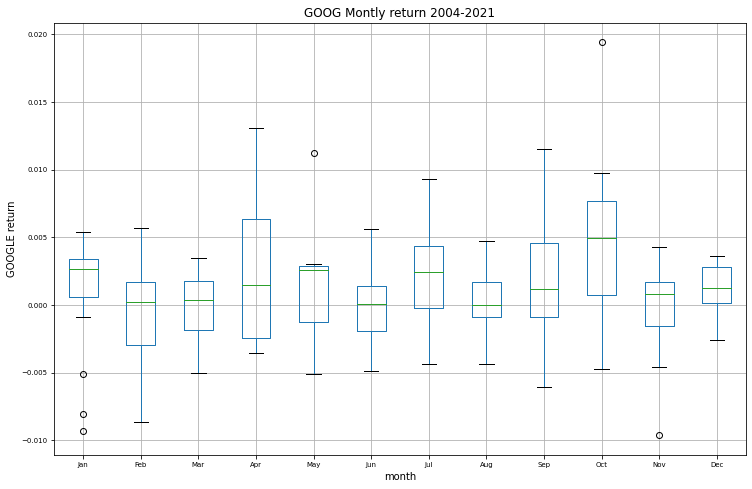

In [52]:
google_monthly_return_list.boxplot(column='monthly_return', by='month', figsize=(12,8))

ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['Jan','Feb','Mar','Apr','May','Jun',\
        'Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(labels)
ax.set_ylabel('GOOGLE return')
plt.tick_params(axis='both', which='major', labelsize=7)
plt.title("GOOG Montly return 2004-2021")
plt.suptitle("")
plt.savefig('meanreturnbymonth.jpg')
plt.show()

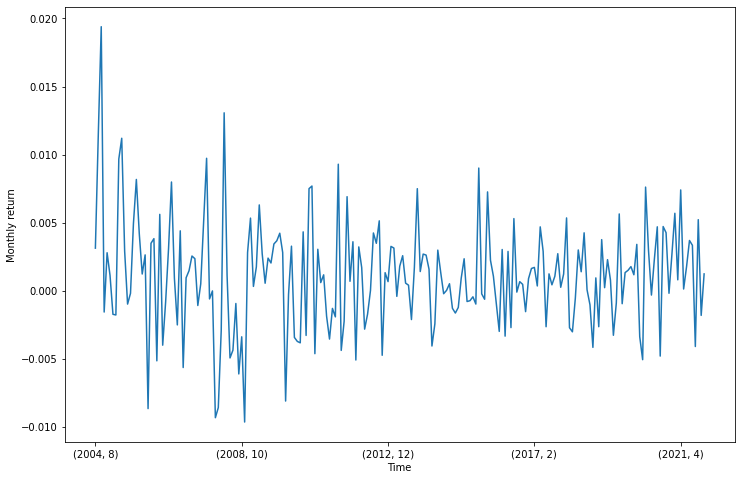

In [53]:
fig = plt.figure(figsize=(12,8))
google_daily_long['Adj Close'].pct_change().groupby(
    [google_daily_long['Adj Close'].index.month])

ax1 = fig.add_subplot(111, ylabel='Monthly return')
google_monthly_return.plot()
plt.xlabel('Time')
plt.show()



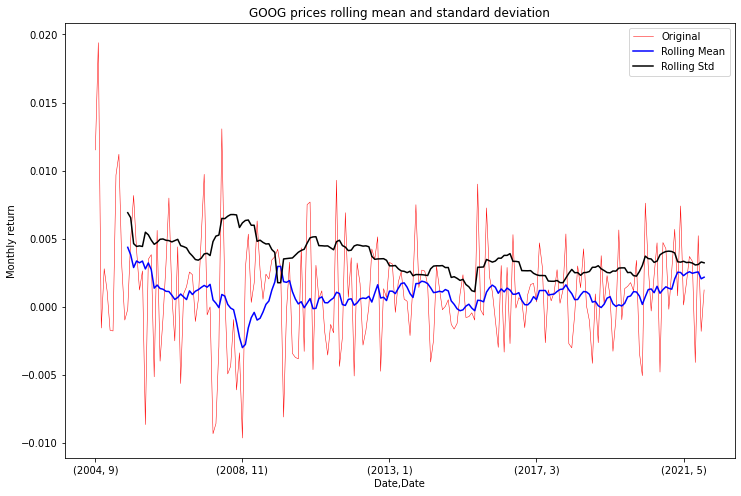

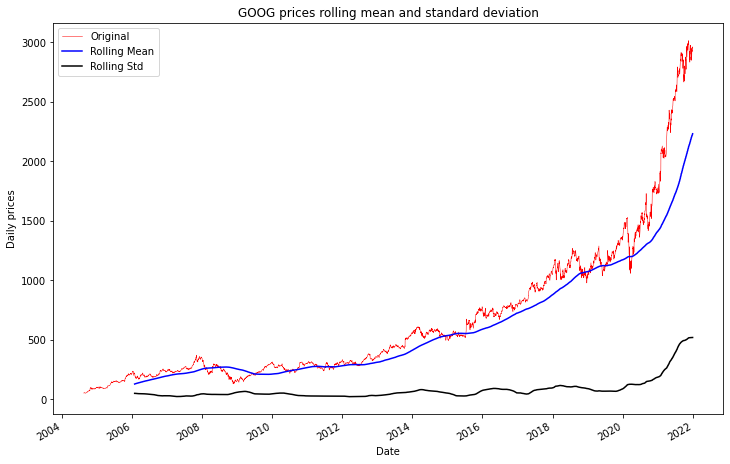

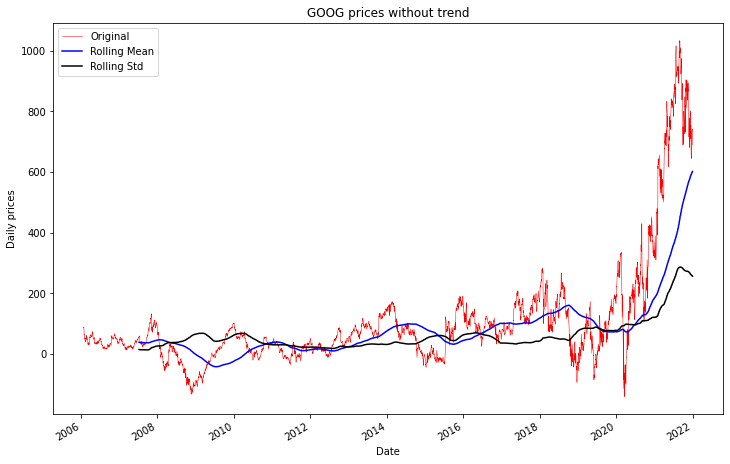

In [54]:
# Displaying rolling statistics
def plot_rolling_stat_ts(ts, titletext,ytext, window_size=12):
    ts.plot(color='red', label='Original', lw=0.5)
    ts.rolling(window_size).mean().plot(
            color='blue',label='Rolling Mean')
    ts.rolling(window_size).std().plot(
            color='black', label='Rolling Std', figsize=(12,8))
    plt.legend(loc='best')
    plt.ylabel(ytext)
    plt.title(titletext)
    plt.show(block=False)


plot_rolling_stat_ts(google_monthly_return[1:],'GOOG prices rolling mean and standard deviation','Monthly return')
plot_rolling_stat_ts(google_daily_long['Adj Close'],'GOOG prices rolling mean and standard deviation','Daily prices',365)

plot_rolling_stat_ts(google_daily_long['Adj Close']-google_daily_long['Adj Close'].rolling(365).mean(),'GOOG prices without trend','Daily prices',365)



Results of Dickey-Fuller Test:
Test Statistic                -1.111840e+01
p-value                        3.515657e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.050000e+02
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                    4.616513
p-value                           1.000000
#Lags Used                       26.000000
Number of Observations Used    4345.000000
dtype: float64


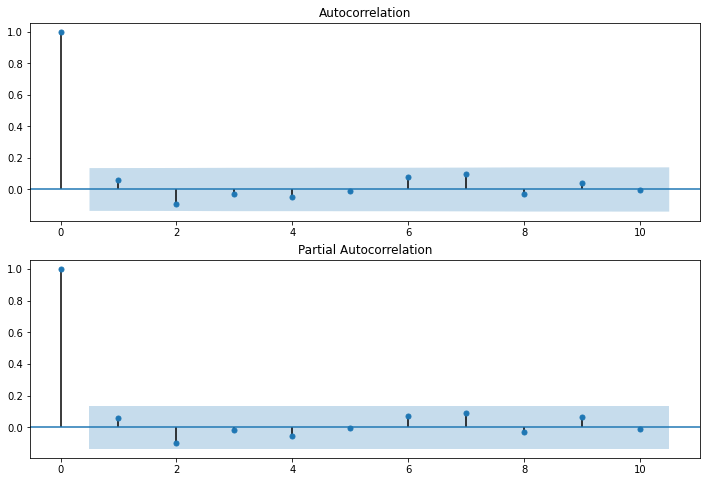

In [55]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[1:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print (dfoutput)

test_stationarity(google_monthly_return[1:])
test_stationarity(google_daily_long['Adj Close'])


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure(figsize=(12,8))
pyplot.subplot(211)
plot_acf(google_monthly_return[1:], ax=pyplot.gca(),lags=10)
pyplot.subplot(212)
plot_pacf(google_monthly_return[1:], ax=pyplot.gca(),lags=10)
pyplot.show()


module 'statsmodels' is installed


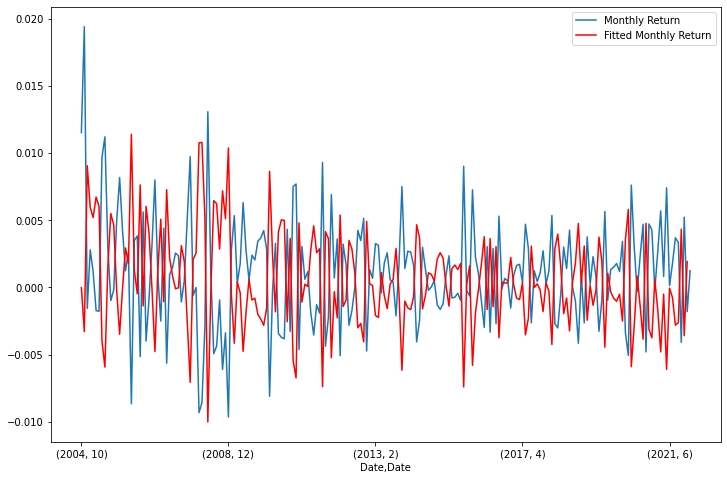

In [56]:
try:
    import statsmodels
    print("module 'statsmodels' is installed")
except ModuleNotFoundError:
    print("module 'statsmodels' is not installed")
    !pip install statsmodels

from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(google_monthly_return[1:], order=(2, 1, 2))
fitted_results = model.fit()
google_monthly_return[1:].plot(figsize=(12,8), label="Monthly Return", legend=True)
fitted_results.fittedvalues.plot(color='red', label="Fitted Monthly Return",legend=True)
plt.show() 